['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
MT-11020 textures\ABS\MT-11020
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 181.87433638603773
file textures\ABS\MT-11020\MT-11020_spectrum.txt
MT-11020_ABS
['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
MT-11020 textures\PP\MT-11020
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 121.7288888833675
file textures\PP\MT-11020\MT-11020_spectrum.txt
MT-11020_PP
{'MT-11020_ABS': 'textures\\ABS\\MT-11020\\MT-11020_spectrum.txt', 'MT-11020_PP': 'textures\\PP\\MT-11020\\MT-11020_spectrum.txt'}
saved texture file to  textures\textures.json


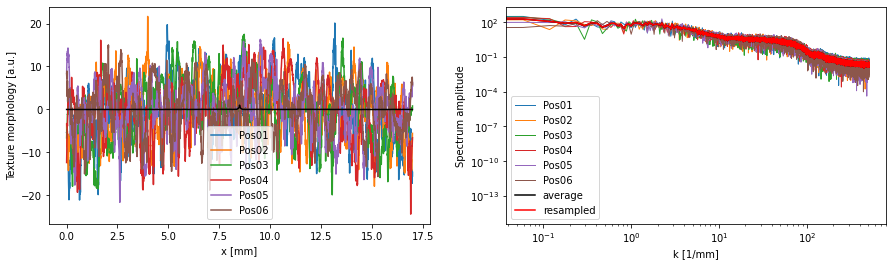

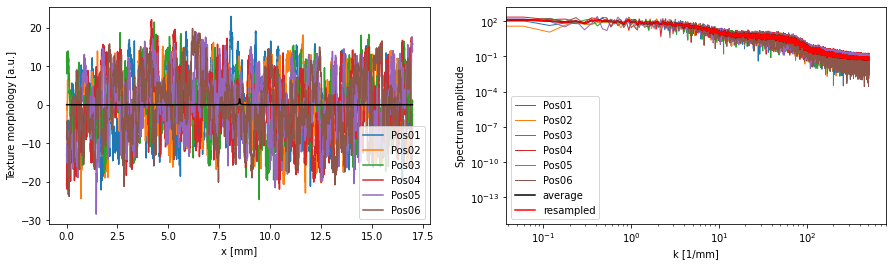

In [124]:
from  texture_vibration_generator import *
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal



sample ="MT-11020"

path = "textures\\ABS\\"

directories = os.listdir(path)

print(directories)
directories = [file for file in directories if os.path.isdir(os.path.join(path,file))]
print(directories)

sample_names = directories

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = fs/2
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y


def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



N_spectrum = 1000
N_spectrum = 17501

cutoff_fine_texture = 15 # peaks /mm


output_N_spectrum = 512*2
output_fs_spatial = 512*2 # samples/mm


# for path_name in [os.path.join(path, sample) for sample in sample_names]:

json_dictionary = dict()

for material in ['ABS', 'PP']:
    
    path = "textures\\%s\\"%(material)

    directories = os.listdir(path)

    print(directories)
    directories = [file for file in directories if os.path.isdir(os.path.join(path,file))]
    print(directories)

    sample_names = directories
    for sample in sample_names:
        path_name = os.path.join(path, sample) 
        print(sample, path_name)

        # listing all profile names inside
        files = os.listdir(path_name)


        # select the proper extension
        files = [file for file in files if ".ua2" in file]
        print(files)


        fig, ax = plt.subplots(1,2, figsize=(15,4))


        profile_list = []
        profile_x_list = []

        spectrum_list = []
        spectrum_freqs_list = []
        for file in files:
            filename = os.path.join(path_name, file)
    #         print(filename)

            # load the resolution:
            with open(filename, "r") as f:
                line = f.readline()
                if "Profil" not in line:
                    break
                else:
                    line = f.readline()

                    # Read the x-length and x-resolution
                    # example line: X-Maß = 17.50 X-Auflösung = 1000.00 Punkte/Zeile: 17501
                    data = re.findall(r"[-+]?\d*\.\d+|\d+", line)
    #                 print(line)
                    x_length, x_resolution, x_total = [float(value) for value in data]
#                     print(file, x_length, x_resolution, x_total)

            # Load all the profile data and construct the x and y topography
            profile = np.loadtxt(filename, skiprows=2)

            assert profile.size == x_total, "Confirm that the profile size is the same as the extracted x_total in the .ua2 header"


            # trim to a multiple of the output_N_spectrum
            profile = profile[:np.floor_divide(profile.size, output_N_spectrum)*output_N_spectrum]


            x_total = profile.size
            fs_spatial = x_resolution

            
            resample_num = np.int(output_fs_spatial/fs_spatial*x_total)
            
#             print(profile.size, resample_num)
#             profile = signal.resample(profile, resample_num)
            fs_spatial = output_fs_spatial
            x_total = profile.size



            x = np.linspace(0, x_total/fs_spatial, x_total)
    #         x = np.linspace(0,x_length, profile.size)

            # Detrend the profile lienarly
            profile = signal.detrend(profile, type='linear')
            
            profile = profile-np.mean(profile)
            
            # calculate maximum profile peak-peak
            profile_ptp = np.ptp(profile)
#             print("Maximum profile step height,", profile_ptp)
            
            
            
            # high pass filter
            
            order = 5
            fs = fs_spatial
            
            
            lowcut = cutoff_fine_texture
#             lowcut = 1
            highcut = 256

#             profile = butter_bandpass_filter(profile,lowcut, highcut, fs_spatial, order=order)
            
    
            b,a = butter_bandpass(lowcut, highcut, fs_spatial, order=order)
            zf = signal.lfiltic(b,a, profile)
            
#             profile = signal.lfilter(b, a, profile,)
            
            
            
#             print(zf)
#             profile, zf = signal.lfilter(b, a, profile, zi=zf)

#             profile = butter_highpass_filter(profile, cutoff_fine_texture, fs, order)

            
            
            # trim the profile to a multiple of output_N_spectrum
            # profile = profile - np.mean(profile)
            
            # windowing
            window = np.hamming(profile.size)
            window = np.hanning(profile.size)
#             profile *= window

            
            # Calculate the spectrum from the profile
            spectrum_profile = np.fft.fft(profile, norm='ortho')

            spectrum_spatial_freq = np.fft.fftfreq(spectrum_profile.size, d=np.diff(x)[0])

            # Absolute of the profile
            spectrum_profile = np.abs(spectrum_profile)
            
            # Shift everything to center
            spectrum_profile = np.fft.fftshift(spectrum_profile)
            spectrum_spatial_freq = np.fft.fftshift(spectrum_spatial_freq)
            



            # append profile and spectrum profile to the list for post averaging
            profile_list.append(profile)
            profile_x_list.append(x)
            spectrum_list.append(spectrum_profile)
            spectrum_freqs_list.append(spectrum_spatial_freq)


            posfilename = os.path.splitext(file)[0]
            
            # Plot each profile
            plt.sca(ax[0])

            plt.plot(x, profile, label=posfilename)
            plt.xlabel("x [mm]")
            plt.ylabel("Texture morphology [a.u.]")

            plt.legend()
            plt.sca(ax[1])

#             plt.plot(spectrum_spatial_freq, np.abs(spectrum_profile), lw=1, label=posfilename)
            plt.loglog(spectrum_spatial_freq, np.abs(spectrum_profile), lw=1, label=posfilename)



        plt.sca(ax[1])
    
        # Average all the spectrums
        spectrum_profiles = np.mean(spectrum_list, axis=0)
        spectrum_spatial_freqs = np.mean(spectrum_freqs_list, axis=0)
#         plt.plot(spectrum_spatial_freqs, spectrum_profiles.real, c='k', label="average")
        plt.loglog(spectrum_spatial_freqs, spectrum_profiles.real, c='k', label="average")

        # Resample to a specific number of output_N_spectrum=1024. This way all the spectrums have the same size
        
#         spectrum_profiles = signal.resample(spectrum_profiles, num=output_N_spectrum)

        
        
        spectrum_spatial_freqs = np.fft.fftshift(np.fft.fftfreq(spectrum_profiles.size, d=1/fs_spatial))
        plt.plot(spectrum_spatial_freqs, spectrum_profiles.real, c='r', label="resampled")
#         plt.xlim(-50,50)
    #     print(spectrum_profiles.size, spectrum_spatial_freqs.max())

        plt.legend()

        plt.xlabel("k [1/mm]")
        plt.ylabel("Spectrum amplitude")

        # Synthesize the texture from spectrum

        plt.sca(ax[0])

        texture_profile = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(spectrum_profiles)))
        texture_x = np.linspace(0, texture_profile.size/fs_spatial, texture_profile.size)
        plt.plot(texture_x, texture_profile, c='k', label="Synthetic texture")



        outputname = "%s_spectrum.png"%(sample)
        output_filename = os.path.join(path_name, outputname)
        plt.savefig(output_filename)

        output_filename_texture = "%s_spectrum.txt"%(sample)

        data = np.array([spectrum_spatial_freqs,spectrum_profiles]).T

        output_filename_texture = "%s_spectrum.txt"%(sample)
        output_filename = os.path.join(path_name, output_filename_texture)


        np.savetxt(output_filename, data, delimiter=',', header='spatial freqs [1/mm], spectrum [a.u.]')    
    #     plt.close()
        print("Maximum spectrum step height,", np.ptp(spectrum_profiles))

        print("file", output_filename)
        
        key_name = "%s_%s"%(sample,material)
        print(key_name)
        json_dictionary[key_name] = output_filename
        
        break
print(json_dictionary)

path = "textures"
filename_json = os.path.join(path, "textures.json")
with open(filename_json, 'w') as outfile:
    json.dump(json_dictionary, outfile, indent=4)
print('saved texture file to ', filename_json)

fs 80


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


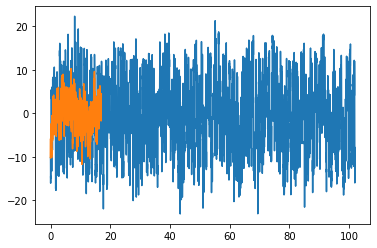

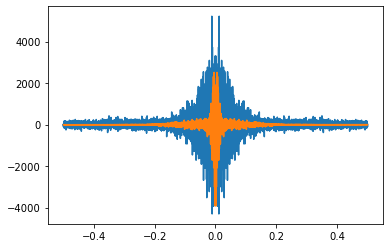

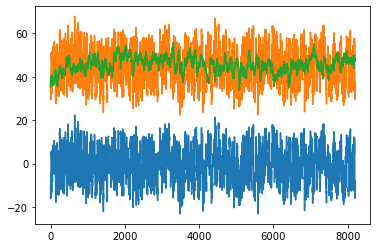

In [69]:
profiles_all = np.concatenate(profile_list)
profiles_x_all = np.concatenate(profile_x_list)

profiles_all2 = np.mean(profile_list, axis=0)
profiles_x_all2 = np.mean(profile_x_list, axis=0)


#         velocity = i+1
# N_audio_segment = np.int(fs_audio/(fs_texture*velocity)*N_texture)
# N_audio_segment = round_up_to_even(N_audio_segment)

profiles_all2 , profiles_x_all2 = signal.resample(profiles_all2, 1024*8, profiles_x_all2)
profiles_all , profiles_x_all = signal.resample(profiles_all, 1024*8, profiles_x_all)


cutoff = 10
fs = np.round(1/np.diff(profiles_x_all)[0]).astype(np.int)
print("fs",fs)
# profiles_all = butter_highpass_filter(profiles_all, cutoff, fs, order=5 )
# profiles_all = butter_lowpass_filter(profiles_all, cutoff, fs, order=5 )


plt.plot(profiles_x_all,profiles_all)
plt.plot(profiles_x_all2,profiles_all2)


ft_profiles = np.fft.fft(profiles_all)
ft_freqs = np.fft.fftfreq(profiles_all.size)

ft_profiles2 = np.fft.fft(profiles_all2)
ft_freqs2 = np.fft.fftfreq(profiles_all2.size)

plt.figure()
plt.plot(ft_freqs, ft_profiles)
plt.plot(ft_freqs2, ft_profiles2)

lim = 0.05
# plt.xlim(-lim,lim)


iprofile = np.fft.ifft(ft_profiles)
iprofile2 = np.fft.ifft(ft_profiles2)
plt.figure()
plt.plot(profiles_all)
plt.plot(iprofile + np.ptp(profiles_all))
plt.plot(iprofile2 + np.ptp(profiles_all))

(8291, 100, 8192)

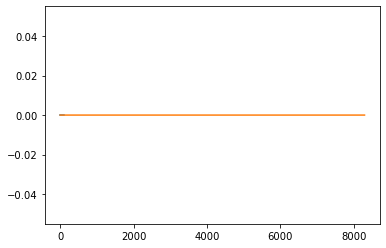

In [73]:
impulse = signal.unit_impulse(profiles_all2.size, idx=0)
impulse = signal.unit_impulse(100, idx=0)

impulse = np.zeros(100)

conv = np.convolve(profiles_all2,impulse)

plt.plot(impulse)

plt.plot(conv)

conv.size, impulse.size, profiles_all2.size

In [263]:
def generate_impulse_train(velocity, N_frame, fs, delay=0):
    """
    Generates an impulse train respective of the velocity, in frame of size N_frame, sampled at fs
    counting a delay number of samples (float for average finger_velocity) since the last impulse.
    """
    n_impulse_velocity_period = (1/velocity)*fs

    idx = np.array([])

    idx = np.arange(-delay, N_frame, n_impulse_velocity_period)

    
    idx = idx[np.where(idx>=0)]

    if idx.size == 0:
        delay = delay+N_frame
        impulse = np.zeros(N_frame)
    else:
        delay = N_frame-idx[-1]
        idx = np.array(idx).astype(np.int)
        
        impulse = signal.unit_impulse(N_frame, idx)
    
    return (impulse, delay)    
    
    


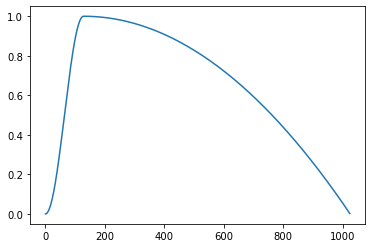

In [412]:

def easing_impulse_window(a, N):
    
    assert isinstance(a, int), "a must be int"
    
    x = np.arange(a)
    
    A = 0.5-np.cos((x/a)*np.pi)/2
    
    b = N-a
    x = np.arange(b )

    B = 0.5+np.cos((x/(b))*np.pi)/2
    B = -np.power((x/b),2)+1
    
    window = np.concatenate([A,B])
    return window

def texture_easing_window(texture, easing_a, N_easing):
    
#     assert texture.size >= N_easing, "array size must be equal or larger than N_easing"
    if texture.size <= N_easing:
        easing_a = np.int(easing_a/N_easing*texture.size)
        N_easing = texture.size
    
    window = easing_impulse_window(easing_a, N_easing)
    texture = texture[:window.size]*window
    return texture
    
    
    

def add_signal_buffer(buffer_audio, sig):

    # pad the existing buffer to fit the new data
    N_signal = sig.size
    if N_signal > buffer_audio.size:
        print("a", buffer_audio.size,N_signal)

        buffer_audio = np.pad(buffer_audio, (0, N_signal-buffer_audio.size))
    else: 
        print( buffer_audio.size,N_signal)
        sig = np.pad(sig, (0, buffer_audio.size-N_signal))
        
        
    buffer_audio = buffer_audio+sig
    return buffer_audio

def extract_signal_buffer(buffer_audio, N_frame):
    
#     assert buffer_audio.size > N_frame, "not enough samples in buffer_audio?"
    if buffer_audio.size < N_frame:
        N_frame = buffer_audio.size
    output = buffer_audio[:N_frame]
    buffer_audio = buffer_audio[N_frame:]
    return output, buffer_audio
    



def resample_texture(texture, k_spatial, fs, velocity):
    
    assert velocity>0, "velocity must be non-zero, otherwise just add zeros"
    N_texture = texture.size
    N_resample = np.int(fs/(k_spatial*velocity)*N_texture)
    
    texture_resample = signal.resample(texture, N_resample)
    return texture_resample

def convolve_texture_sample(texture_frame, impulses):
    

    calculated_signal = np.convolve(impulses, texture_frame, mode='full')

    
    return calculated_signal


window = easing_impulse_window(128, 1024)
plt.plot(window)


a 0 6143
a 2047 6143
a 2047 6143
a 2047 6143
a 2047 6143
a 2047 6143
a 2047 6143
a 2047 6143
a 2047 6143
a 2047 6143
a 2047 6143
a 2047 6143
a 2047 6143
a 2047 6040
a 1944 5919
a 1823 5813
a 1717 5718
a 1622 5633
a 1537 5556
a 1460 5487


C:\Users\diogo\Anaconda3\lib\site-packages\scipy\signal\waveforms.py:658: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif idx == 'mid':


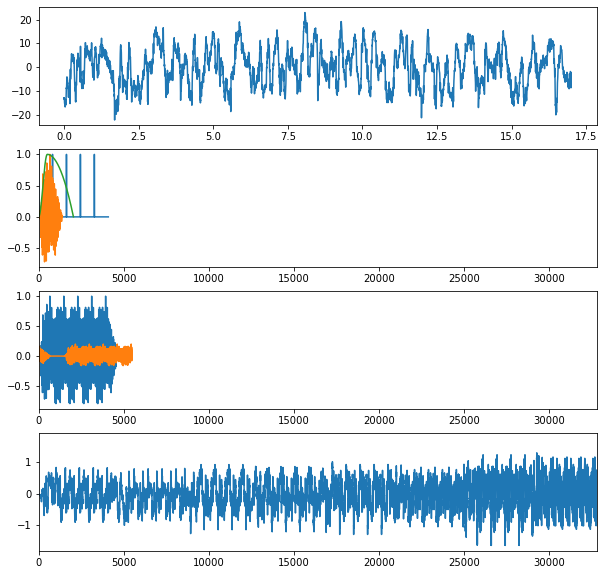

In [417]:

from IPython.display import Audio

profile = profile_list[0]

# profile *= np.hanning(profile.size)

x = profile_x_list[0]
k_spatial = 1024


# profile2 = butter_highpass_filter(profile, cutoff, fs)


fs_audio = 8192
N_frame = 1024*4
frame_duration = N_frame/fs_audio

N_easing = 1024*2
easing_a = 512


# velocity for each frame
velocity = 10 # mm/s

finger_spacing = 1

finger_velocity = velocity*finger_spacing

# Generate an impulse train with the frequency given by velocity
delay = 0
buffer_audio = np.array([])
output_buffer = np.array([])


# for velocity in [10,20,30,40]:
for velocity in np.linspace(10,100,20):

    impulses, delay = generate_impulse_train(finger_velocity, N_frame, fs_audio, delay)




    texture_frame = resample_texture(profile, k_spatial, fs_audio, velocity)
    #

    # easing the impulse signal
    texture_frame = texture_easing_window(texture_frame, easing_a, N_easing)

    texture_frame = texture_frame/np.max(np.abs(texture_frame))





    # texture_frame = np.hanning(100)


    calculated_signal = convolve_texture_sample(texture_frame, impulses)




    # calculated_signal = np.pad(calculated_signal, (0,8192))

    # pad the existing buffer to fit the new data
    N_signal = calculated_signal.size

    buffer_audio = add_signal_buffer(buffer_audio, calculated_signal)
    
    output, buffer_audio = extract_signal_buffer(buffer_audio, N_frame)
    
    output_buffer = np.concatenate([output_buffer, output])
    


aux = np.roll(calculated_signal, 1500)

# calculated_signal = calculated_signal+aux

vol = 100

calculated_signal = calculated_signal/np.max(calculated_signal)*vol/100





# Generating the impulse train

fig, axes = plt.subplots(4,1, figsize=(10,10))

plt.sca(axes[0])

plt.plot(x, profile)

plt.sca(axes[1])
plt.plot(impulses)

plt.plot(texture_frame)

window = easing_impulse_window(easing_a, N_easing)

plt.plot(window)


plt.xlim(0,2**15)
plt.sca(axes[2])

plt.plot(calculated_signal)
plt.plot(aux/5)

plt.xlim(0,2**15)


plt.sca(axes[3])

plt.plot(output_buffer)


plt.xlim(0,2**15)
Audio(output_buffer/10, rate=fs_audio, normalize=False)
# Audio(aux, rate=fs_audio)


a 0 3071


C:\Users\diogo\Anaconda3\lib\site-packages\scipy\signal\waveforms.py:658: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif idx == 'mid':


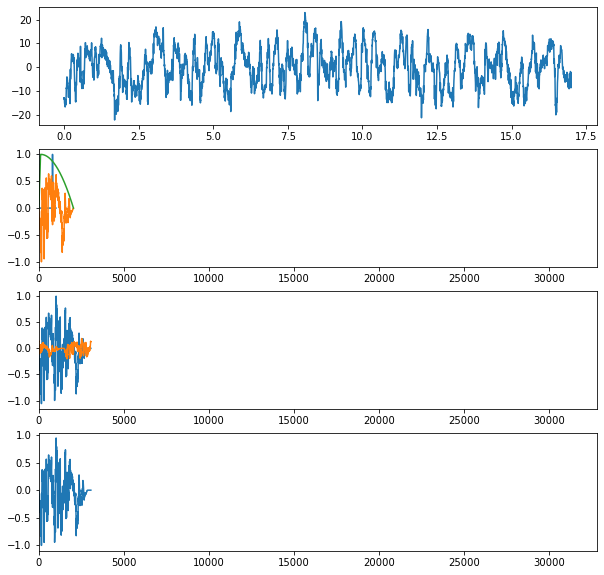

In [409]:

from IPython.display import Audio

profile = profile_list[0]

# profile *= np.hanning(profile.size)

x = profile_x_list[0]
k_spatial = 1024


# profile2 = butter_highpass_filter(profile, cutoff, fs)


fs_audio = 8192
N_frame = 1024*1
frame_duration = N_frame/fs_audio

N_easing = 1024*2
easing_a = 128


# velocity for each frame
velocity = 10 # mm/s

finger_spacing = 1

finger_velocity = velocity*finger_spacing

# Generate an impulse train with the frequency given by velocity
delay = 0



impulses, delay = generate_impulse_train(finger_velocity, N_frame, fs_audio, delay)




texture_frame = resample_texture(profile, k_spatial, fs_audio, velocity)
#

# easing the impulse signal
texture_frame = texture_easing_window(texture_frame, easing_a, N_easing)

# texture_frame = texture_frame/np.max(np.abs(texture_frame))





# texture_frame = np.hanning(100)


calculated_signal = convolve_texture_sample(texture_frame, impulses)



buffer_audio = np.array([])


# calculated_signal = np.pad(calculated_signal, (0,8192))

# pad the existing buffer to fit the new data
N_signal = calculated_signal.size

buffer_audio = add_signal_buffer(buffer_audio, calculated_signal)


aux = np.roll(calculated_signal, 1500)

# calculated_signal = calculated_signal+aux

vol = 100

calculated_signal = calculated_signal/np.max(calculated_signal)*vol/100





# Generating the impulse train

fig, axes = plt.subplots(4,1, figsize=(10,10))

plt.sca(axes[0])

plt.plot(x, profile)

plt.sca(axes[1])
plt.plot(impulses)

plt.plot(texture_frame)

window = easing_impulse_window(easing_a, N_easing)

plt.plot(window)


plt.xlim(0,2**15)
plt.sca(axes[2])

plt.plot(calculated_signal)
plt.plot(aux/5)

plt.xlim(0,2**15)


plt.sca(axes[3])

plt.plot(buffer_audio)


plt.xlim(0,2**15)
Audio(buffer_audio/10, rate=fs_audio, normalize=False)
# Audio(aux, rate=fs_audio)


In [404]:

buffer_audio = np.array([])
buffer_audio = np.zeros(5000)

# calculated_signal = np.pad(calculated_signal, (0,8192))

buffer_audio = add_signal_buffer(buffer_audio, calculated_signal)
buffer_audio.size,buffer



5000 3071


(5000, array([0., 0., 0., ..., 0., 0., 0.]))

In [215]:
np.arange(0,N_frame, n_impulse_velocity_period)+frame_phase
np.remainder(10,3)

idx = np.arange(-5, 10, 222)
print(idx)
idx[np.where(idx>0)]

[-5]


array([], dtype=int32)

In [290]:
Audio(np.sin(np.linspace(0, 3000, 20000)), rate=20000)


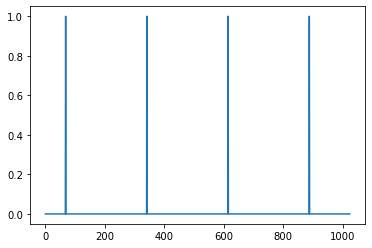

In [260]:
plt.plot(impulses)

29299 26112.0 3187


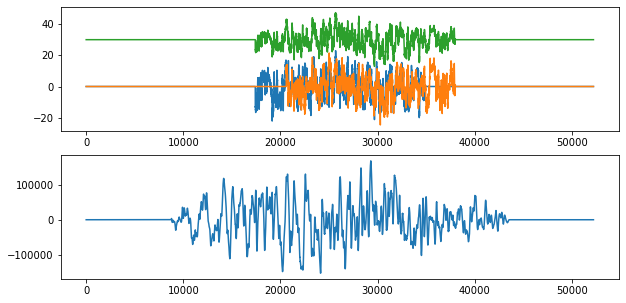

In [106]:

in1 = profile_list[0]
in2 = profile_list[2]

in1 = np.pad(in1, in1.size)
in2 = np.pad(in2, in2.size)

corr= signal.correlate(in1, in2, mode='same')

corr_argmax = np.argmax(corr)

roll_idx = np.int(corr_argmax-in1.size/2)
print(corr_argmax, in1.size/2, roll_idx)
in2 = np.roll(in2,roll_idx)

in3 = np.mean([in1,in2], axis=0)+30

fig, axes = plt.subplots(2,1, figsize=(10,5))
plt.sca(axes[0])

plt.plot(in1)
plt.plot(in2)
plt.plot(in3)

plt.sca(axes[1])

plt.plot(corr)

In [107]:
corr.size,in1.size*2

(52224, 104448)

17825

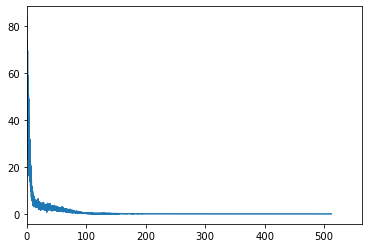

In [9]:
spectrum_profiles = np.mean(spectrum_list, axis=0)
spectrum_spatial_freqs = np.mean(spectrum_freqs_list, axis=0)
plt.plot(spectrum_spatial_freqs, spectrum_profiles)
plt.xlim(xmin=0,)
spectrum_profiles.size

In [6]:
json_filename = os.path.join("textures", "textures.json")


with open(json_filename) as json_file:
    data = json.load(json_file)
    
for key in data:
    print(key, data[key])

MT-11020_ABS textures\ABS\MT-11020\MT-11020_spectrum.txt
MT-11020_PP textures\PP\MT-11020\MT-11020_spectrum.txt


textures\ABS\MT-11020\MT-11020_spectrum.txt
2 400 1024 3
frame 0.7326294707724806 -0.007229628747911153
framefilt 0.7712682251237777 -0.0017528721293498851


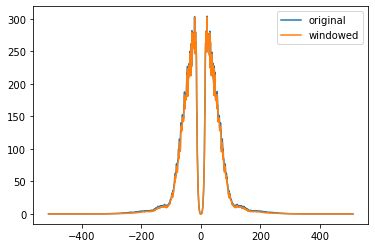

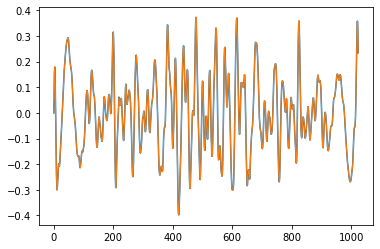

In [26]:
from  texture_vibration_generator import *
texture_name = list(data.keys())[0]
texture_file = data[texture_name]
print(texture_file)


freqs, spectrum = np.loadtxt(texture_file, delimiter=',', unpack=True)


# spectrum  = spectrum-np.mean(spectrum)
# spectrum = np.clip(spectrum,a_min=10, a_max=120)
window = np.hamming(spectrum.size)

easing = window_easing(spectrum.size, 128)

specwin = spectrum*window
plt.plot(freqs, spectrum, label='original')

plt.plot(freqs, specwin, label='windowed')


plt.legend()


plt.figure()
fs_spatial = 1024
velocity_probe = 1
N_frame = spectrum.size*1
fs_audio = fs_spatial
t_frame, sig_frame = estimate_texture_signal(spectrum, fs_spatial, velocity_probe, N_frame, fs_audio, )


sig = generate_audio_from_spectrum(spectrum)
t_frame, sig_frame = estimate_texture_signal(spectrum, fs_spatial, velocity_probe, N_frame, fs_audio, )


sig_frame = sig_frame*window_easing(y.size, 256)

print(2, 400, fs_spatial, order)

print('frame',np.ptp(sig_frame), np.mean(sig_frame))

order = 3
b,a = butter_bandpass(5, 400, fs_spatial, order=order)
sig_frame = signal.lfilter(b, a, sig_frame, )

# sig_frame = sig_frame[:-order]

print('framefilt',np.ptp(sig_frame), np.mean(sig_frame))

sig = sig_frame
y = sig
# y = np.fft.ifft(np.fft.fftshift(spectrum))
# y = np.fft.ifft(spectrum)

# y = np.fft.fftshift(y)
plt.plot(y)

y = np.real(y)



# y = np.fft.fftshift(y)
# y = np.fft.fftshift(y)
# plt.plot(y)

plt.plot(np.concatenate([y]),lw=1)
# plt.plot(y)

# y = np.fft.ifft(np.fft.fftshift(specwin))
# plt.plot(y*window)


# plt.plot(sig_frame)

cutoff = 30
sig_frame = butter_lowpass_filter(sig_frame, cutoff, fs_spatial)
# sig_frame = butter_highpass_filter(sig_frame, cutoff, fs_spatial)
# plt.plot(sig_frame)
# plt.plot(sig_frame*window)
# plt.plot(sig_frame*easing)
# plt.plot(sig_frame*easing*window)


# plt.ylim(-1,1)

# plt.xlim(250,260)

# plt.figure()

# newspec = np.fft.fftshift(np.fft.fft(sig_frame))
# plt.plot(newspec)

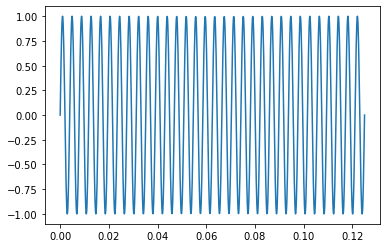

In [51]:
fs_audio = 8192

N_audio_segment = 512*2
t_frame = np.linspace(0, N_audio_segment/fs_audio, fs_audio)
t_frame = np.linspace(0, N_audio_segment/fs_audio, N_audio_segment)
sig_frame = np.sin(2*np.pi*(256)*t_frame)

plt.plot(t_frame, sig_frame)

In [54]:
p.terminate()

[  0 804] [    0   804  1606 ... -3197 -2405 -1606]
* done


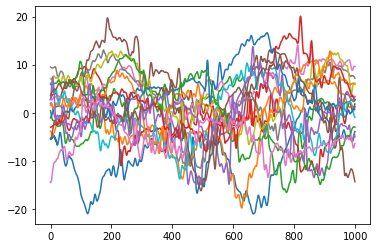

In [3]:
N_spectrum = 1000
profile_split = np.array_split(profile, np.arange(N_spectrum,x_total,N_spectrum).astype(np.int))
profile_split = [p for p in profile_split if p.size==N_spectrum]
[p.shape for p in profile_split]


for p in profile_split:
    plt.plot(p)


['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
MT-11020 textures\ABS\MT-11020
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Pos01.ua2 17.5 1000.0 17501.0
done
Pos02.ua2 17.5 1000.0 17501.0
done
Pos03.ua2 17.5 1000.0 17501.0
done
Pos04.ua2 17.5 1000.0 17501.0
done
Pos05.ua2 17.5 1000.0 17501.0
done
Pos06.ua2 17.5 1000.0 17501.0
done
file textures\ABS\MT-11020\MT-11020_spectrum.png


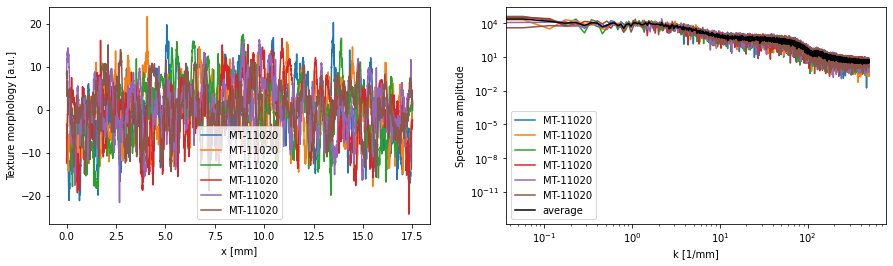

In [32]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal



sample ="MT-11020"


path = "textures\\ABS\\"

directories = os.listdir(path)

print(directories)
directories = [file for file in directories if os.path.isdir(os.path.join(path,file))]
print(directories)

sample_names = directories


N_spectrum = 512
# for path_name in [os.path.join(path, sample) for sample in sample_names]:

for sample in sample_names:
    path_name = os.path.join(path, sample) 
    print(sample, path_name)
    
    # listing all profile names inside
    files = os.listdir(path_name)
    
    
    # select the proper extension
    files = [file for file in files if ".ua2" in file]
    print(files)
    
    
    fig, ax = plt.subplots(1,2, figsize=(15,4))

    
    profile_list = []
    profile_x_list = []
    
    spectrum_list = []
    spectrum_freqs_list = []
    for file in files:
        filename = os.path.join(path_name, file)
#         print(filename)
        
        # load the resolution:
        with open(filename, "r") as f:
            line = f.readline()
            if "Profil" not in line:
                break
            else:
                line = f.readline()
                
                # Read the x-length and x-resolution
                # example line: X-Maß = 17.50 X-Auflösung = 1000.00 Punkte/Zeile: 17501
                data = re.findall(r"[-+]?\d*\.\d+|\d+", line)
#                 print(line)
                x_length, x_resolution, x_total = [float(value) for value in data]
                print(file, x_length, x_resolution, x_total)
        
        # Load all the profile data and construct the x and y topography
        profile = np.loadtxt(filename, skiprows=2)
        
        assert profile.size == x_total, "Confirm that the profile size is the same as the extracted x_total in the .ua2 header"
        x = np.linspace(0,x_length, profile.size)
        
        # Detrend the profile lienarly
        profile = signal.detrend(profile, type='linear')

        # Trim the profile for sequences of N points
        
        
        
        spectrum_profile = np.fft.fft(profile-np.mean(profile))

        spectrum_spatial_freq = np.fft.fftfreq(spectrum_profile.size, d=np.diff(x)[0])

        spectrum_texture = spectrum_profile
        spectrum_profile = np.abs(spectrum_profile)

        spectrum_profile = np.fft.fftshift(spectrum_profile)
        spectrum_spatial_freq = np.fft.fftshift(spectrum_spatial_freq)



        profile_list.append(profile)
        profile_x_list.append(x)
        spectrum_list.append(spectrum_profile)
        spectrum_freqs_list.append(spectrum_spatial_freq)
        
        
        posfilename = os.path.splitext(file)[0]

        plt.sca(ax[0])

        plt.plot(x, profile, label=sample)
        plt.xlabel("x [mm]")
        plt.ylabel("Texture morphology [a.u.]")

        plt.legend()
        plt.sca(ax[1])

#         plt.plot(spectrum_spatial_freq, spectrum_profile/spectrum_profile.max(), label=sample)
#         plt.plot(spectrum_spatial_freq, spectrum_profile, label=sample)
        plt.loglog(spectrum_spatial_freq, spectrum_profile, label=sample)
#         plt.xlim(0,10)
        
      
        
        
        
        print("done")
        
    plt.sca(ax[1])
    spectrum_profiles = np.mean(spectrum_list, axis=0)
    spectrum_spatial_freqs = np.mean(spectrum_freqs_list, axis=0)
#     plt.plot(spectrum_spatial_freqs, spectrum_profiles, c='k', label="average")
    plt.loglog(spectrum_spatial_freqs, spectrum_profiles, c='k', label="average")
#     plt.xlim(0,10)
    
    plt.legend()

    plt.xlabel("k [1/mm]")
    plt.ylabel("Spectrum amplitude")
 
    outputname = "%s_spectrum.png"%(sample)
    output_filename = os.path.join(path_name, outputname)
    plt.savefig(output_filename)
#     plt.close()
    print("file", output_filename)
    break

17501

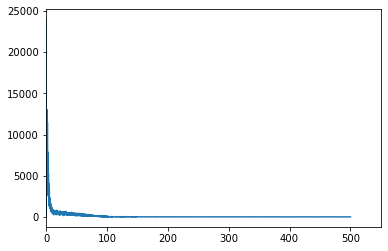

In [29]:

import time
np.random.seed(1234543)
for i in range(10):
#     time.sleep(0.1)
    print(np.random.random())

0.09850781407754472
0.07495302273351623
0.7659084836300032
0.9446902187981655
0.6024796761841354
0.12283680675730968
0.8115156969875904
0.5184904756733948
0.02645078898959985
0.11166743844317795
